<a href="https://colab.research.google.com/github/hargurjeet/LJMU_Thesis/blob/main/ExperimentThresholdAdjustments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Experiments

In [1]:
!git clone https://github.com/hargurjeet/LJMU_Thesis.git

Cloning into 'LJMU_Thesis'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 183 (delta 8), reused 0 (delta 0), pack-reused 160 (from 1)
Receiving objects: 100% (183/183), 32.71 MiB | 7.68 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (26/26), done.


## 1. Importing all the required lib

In [2]:
!pip install pandas openai==0.28

In [3]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Open AI experiments

In [ ]:
# df_open_ai = pd.read_csv("/content/LJMU_Thesis/Processed_output/openai_generated_output.csv")
# df_open_ai.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target,TextualData
0,34,No,Middle Income,6,No,Yes,0,The customer is 34 years old and has indicated...
1,34,Yes,Low Income,5,Yes,No,1,The customer is aged 34 and is a frequent flye...
2,37,No,Middle Income,3,Yes,No,0,The customer is 37 years old and is not a freq...
3,30,No,Middle Income,2,No,No,0,The customer is aged 30 and is not a frequent ...
4,30,No,Low Income,1,No,No,0,"The customer is 30 years old, does not frequen..."


## 3. Generating embeddings for OpenAI model

In [ ]:
# import openai

# openai.api_key = ''

In [ ]:
# def get_embedding(text):
#     response = openai.Embedding.create(
#         model="text-embedding-ada-002",
#         input=text
#     )
#     return response['data'][0]['embedding']

# df_open_ai['Embedding'] = df_open_ai['TextualData'].apply(get_embedding)

In [28]:
# df_open_ai.to_parquet('openai_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/openai_embeddings.parquet'
df_open_ai = pd.read_parquet(parquet_file_path)

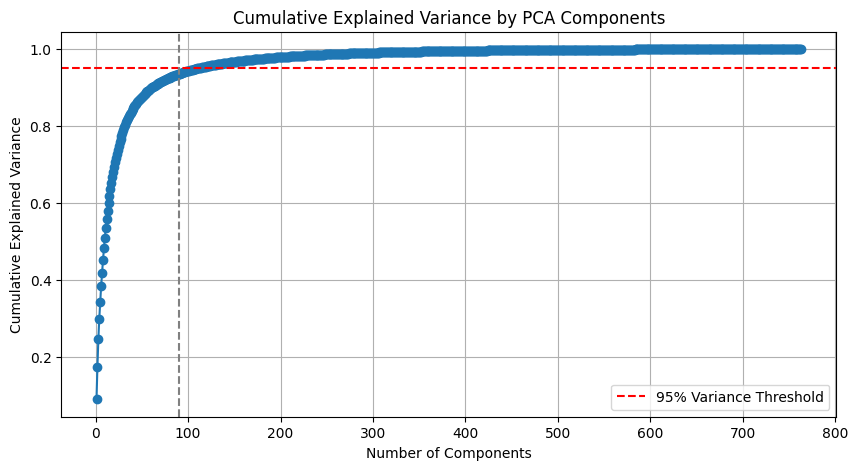

In [29]:
import matplotlib.pyplot as plt
# Prepare data
X = df_open_ai['Embedding'].tolist()
y = df_open_ai['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

## 4. Training models for GPT 3.5 enriched data

In [30]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_open_ai['Embedding'].tolist(),
    df_open_ai['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       153
           1       1.00      0.18      0.31        38

    accuracy                           0.84       191
   macro avg       0.92      0.59      0.61       191
weighted avg       0.87      0.84      0.79       191



In [31]:
xgb_model_gpt = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model_gpt.fit(X_train_pca, y_train)
y_pred = xgb_model_gpt.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.91       153
           1       0.65      0.45      0.53        38

    accuracy                           0.84       191
   macro avg       0.76      0.69      0.72       191
weighted avg       0.83      0.84      0.83       191



## 5. Threshold experiment with XGB classifier

In [32]:
y_pred_proba_gpt = xgb_model_gpt.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba_gpt >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       153
           1       0.52      0.74      0.61        38

    accuracy                           0.81       191
   macro avg       0.72      0.78      0.74       191
weighted avg       0.85      0.81      0.82       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       153
           1       0.59      0.63      0.61        38

    accuracy                           0.84       191
   macro avg       0.75      0.76      0.75       191
weighted avg       0.84      0.84      0.84       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       153
           1       0.66      0.55      0.60        38

    accuracy                           0.85       191


## 6. Building Visuals

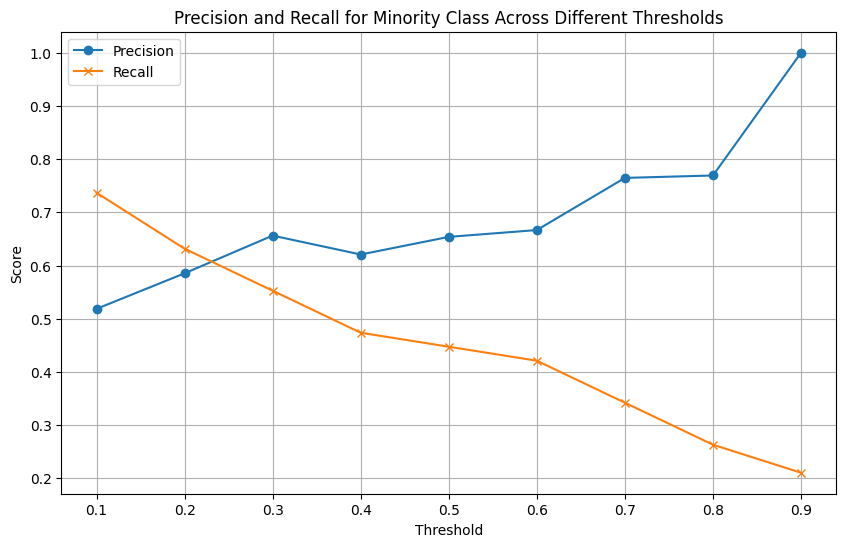

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba_gpt >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## 7. Confustion Matrix

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       153
           1       0.66      0.55      0.60        38

    accuracy                           0.85       191
   macro avg       0.77      0.74      0.76       191
weighted avg       0.85      0.85      0.85       191

{'0': {'precision': 0.8930817610062893, 'recall': 0.9281045751633987, 'f1-score': 0.9102564102564102, 'support': 153.0}, '1': {'precision': 0.65625, 'recall': 0.5526315789473685, 'f1-score': 0.6, 'support': 38.0}, 'accuracy': 0.8534031413612565, 'macro avg': {'precision': 0.7746658805031447, 'recall': 0.7403680770553835, 'f1-score': 0.7551282051282051, 'support': 191.0}, 'weighted avg': {'precision': 0.8459634001778129, 'recall': 0.8534031413612565, 'f1-score': 0.8485300040273863, 'support': 191.0}}


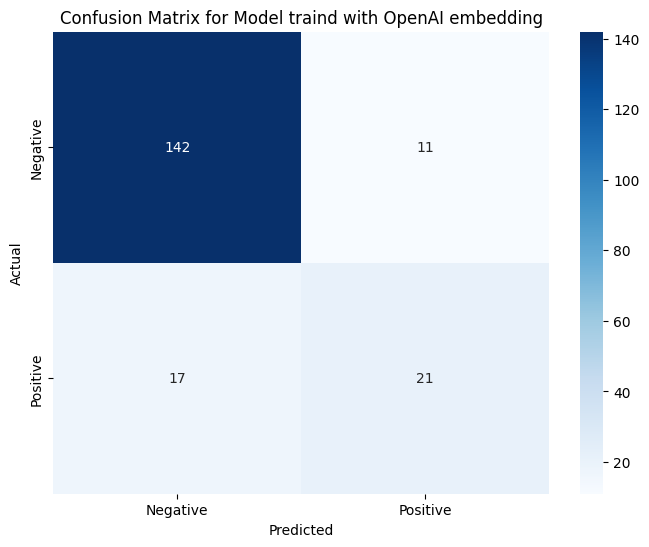

In [43]:
# Set the threshold
threshold = 0.3
y_pred = (y_pred_proba_gpt >= threshold).astype(int)
report_gpt  = classification_report(y_test, y_pred)
print(report_gpt)
report_gpt  = classification_report(y_test, y_pred, output_dict=True)
print(report_gpt)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model traind with OpenAI embedding')
plt.show()

## 8. PR Curve

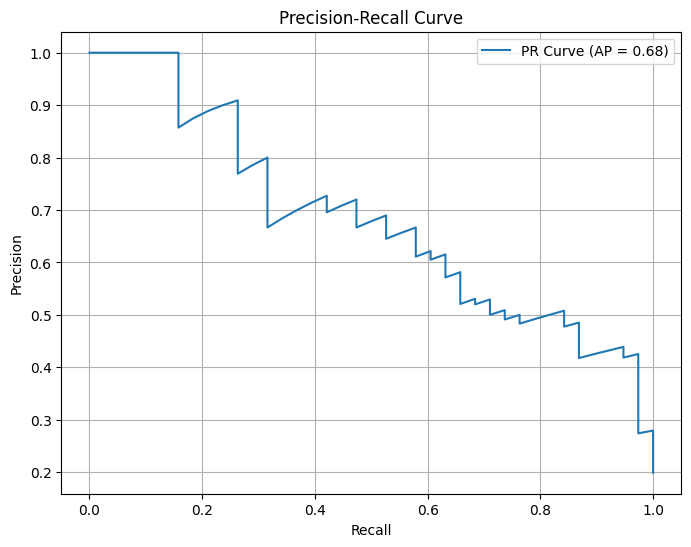

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_gpt)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba_gpt)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Mixtral Expeiments - reading data and embedding

In [ ]:
df_mixtral = pd.read_csv("/content/LJMU_Thesis/Processed_output/mixtral_generated_output.csv")


def get_embedding(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response['data'][0]['embedding']

df_mixtral['Embedding'] = df_mixtral['GeneratedText'].apply(get_embedding)

In [35]:
# df_mixtral.to_parquet('mixtral_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/mixtral_embeddings.parquet'
df_mixtral = pd.read_parquet(parquet_file_path)

## 1.Mixtral modelling experiments

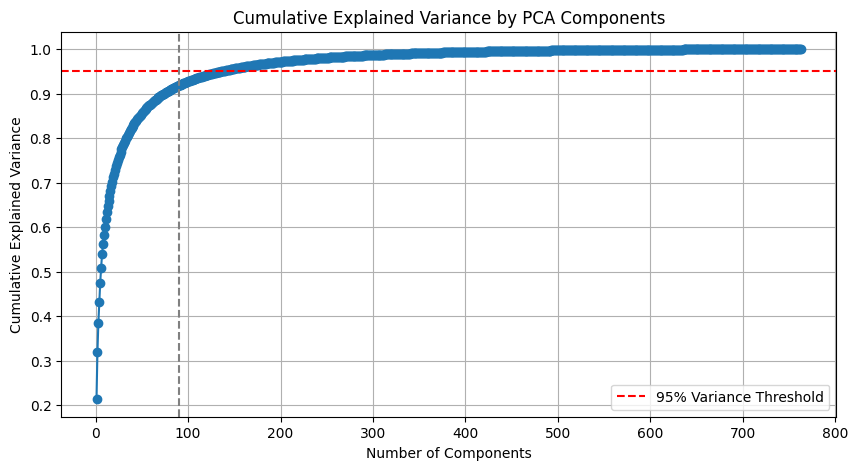

In [12]:
import matplotlib.pyplot as plt
# Prepare data
X = df_mixtral['Embedding'].tolist()
y = df_mixtral['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [36]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_mixtral['Embedding'].tolist(),
    df_mixtral['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       153
           1       0.83      0.13      0.23        38

    accuracy                           0.82       191
   macro avg       0.83      0.56      0.56       191
weighted avg       0.82      0.82      0.77       191



In [37]:
xgb_model_mixtral = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model_mixtral.fit(X_train_pca, y_train)
y_pred = xgb_model_mixtral.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       153
           1       0.57      0.45      0.50        38

    accuracy                           0.82       191
   macro avg       0.72      0.68      0.70       191
weighted avg       0.81      0.82      0.81       191



In [38]:
y_pred_proba_mixtral = xgb_model_mixtral.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba_mixtral >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       153
           1       0.47      0.71      0.57        38

    accuracy                           0.79       191
   macro avg       0.70      0.76      0.71       191
weighted avg       0.83      0.79      0.80       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       153
           1       0.57      0.63      0.60        38

    accuracy                           0.83       191
   macro avg       0.74      0.76      0.75       191
weighted avg       0.84      0.83      0.84       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       153
           1       0.58      0.58      0.58        38

    accuracy                           0.83       191


## 2.PR Curve for Minority Class

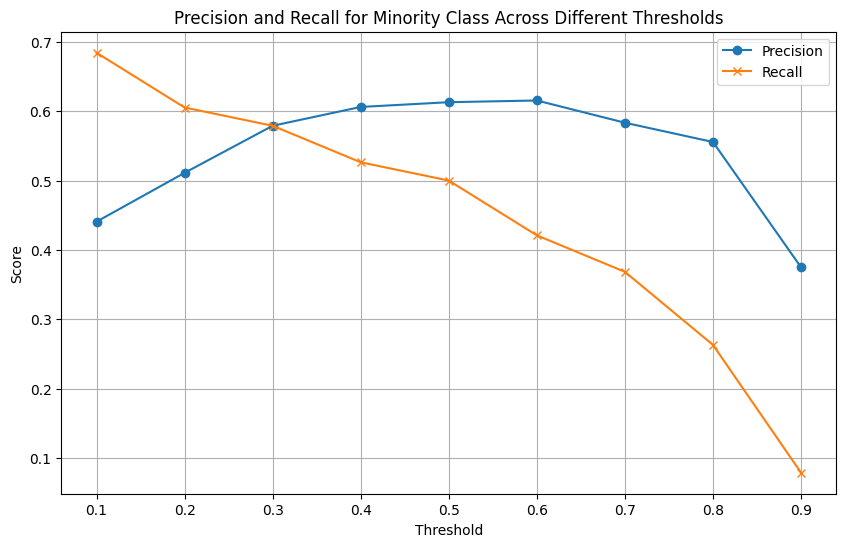

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## 3.Confustion Matrix

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       153
           1       0.58      0.58      0.58        38

    accuracy                           0.83       191
   macro avg       0.74      0.74      0.74       191
weighted avg       0.83      0.83      0.83       191

{'0': {'precision': 0.8954248366013072, 'recall': 0.8954248366013072, 'f1-score': 0.8954248366013072, 'support': 153.0}, '1': {'precision': 0.5789473684210527, 'recall': 0.5789473684210527, 'f1-score': 0.5789473684210527, 'support': 38.0}, 'accuracy': 0.8324607329842932, 'macro avg': {'precision': 0.7371861025111799, 'recall': 0.7371861025111799, 'f1-score': 0.7371861025111799, 'support': 191.0}, 'weighted avg': {'precision': 0.8324607329842932, 'recall': 0.8324607329842932, 'f1-score': 0.8324607329842932, 'support': 191.0}}


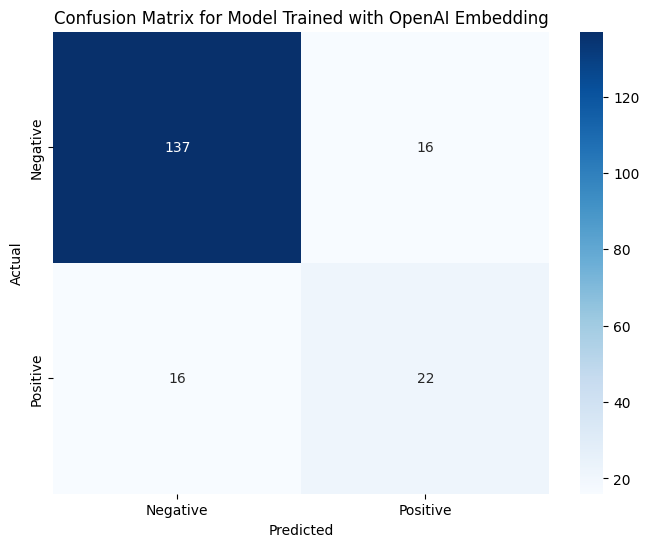

In [42]:
# Set the threshold
threshold = 0.32
y_pred = (y_pred_proba_mixtral >= threshold).astype(int)
report_mixtral = classification_report(y_test, y_pred)
print(report_mixtral)
report_mixtral = classification_report(y_test, y_pred,output_dict=True)
print(report_mixtral)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model Trained with OpenAI Embedding')
plt.show()

## 4. PR Curve

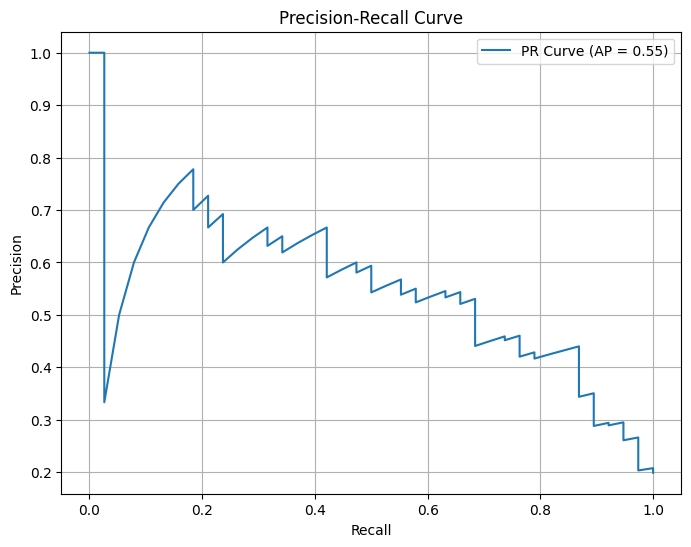

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_mixtral)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba_mixtral)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# LLama Experiments

## 1. Reading Data and generating embeddding

In [ ]:
df_llama = pd.read_csv("/content/LJMU_Thesis/Processed_output/llama_generated_output.csv")

df_llama['Embedding'] = df_llama['GeneratedText'].apply(get_embedding)

In [44]:
df_llama.to_parquet('llama_embeddings.parquet', index=False)

parquet_file_path = '/content/LJMU_Thesis/Processed_output/llama_embeddings.parquet'
df_llama = pd.read_parquet(parquet_file_path)

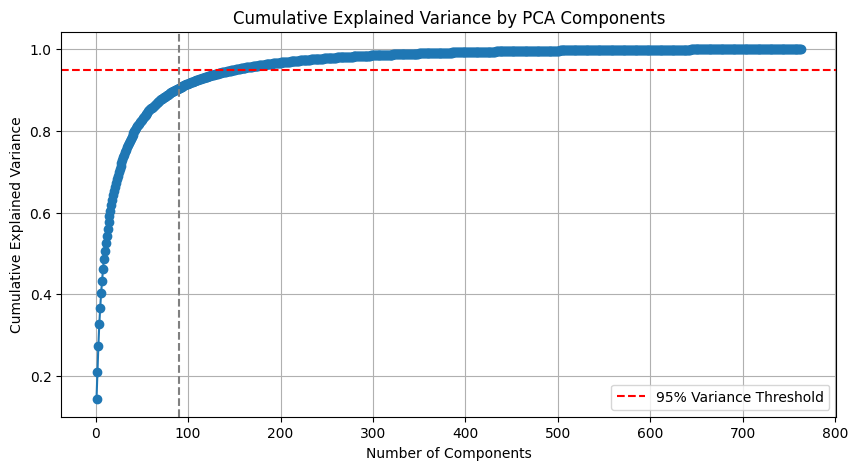

In [45]:
X = df_llama['Embedding'].tolist()
y = df_llama['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

## 2.Training ml models

In [46]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_mixtral['Embedding'].tolist(),
    df_mixtral['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

xgb_model_llama = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model_llama.fit(X_train_pca, y_train)
y_pred = xgb_model_llama.predict(X_test_pca)

report_llama = classification_report(y_test, y_pred)
print(report_llama)

report_llama = classification_report(y_test, y_pred, output_dict=True)
print(report_llama)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       153
           1       0.50      0.05      0.10        38

    accuracy                           0.80       191
   macro avg       0.65      0.52      0.49       191
weighted avg       0.75      0.80      0.73       191

              precision    recall  f1-score   support

           0       0.88      0.92      0.89       153
           1       0.58      0.47      0.52        38

    accuracy                           0.83       191
   macro avg       0.73      0.69      0.71       191
weighted avg       0.82      0.83      0.82       191

{'0': {'precision': 0.875, 'recall': 0.9150326797385621, 'f1-score': 0.8945686900958466, 'support': 153.0}, '1': {'precision': 0.5806451612903226, 'recall': 0.47368421052631576, 'f1-score': 0.5217391304347826, 'support': 38.0}, 'accuracy': 0.8272251308900523, 'macro avg': {'precision': 0.7278225806451613, 'recall': 0.6943584451324389, 'f1-score

In [47]:
y_pred_proba_llama = xgb_model_llama.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba_llama >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       153
           1       0.45      0.66      0.53        38

    accuracy                           0.77       191
   macro avg       0.68      0.73      0.69       191
weighted avg       0.81      0.77      0.78       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       153
           1       0.51      0.61      0.55        38

    accuracy                           0.81       191
   macro avg       0.70      0.73      0.72       191
weighted avg       0.82      0.81      0.81       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       153
           1       0.57      0.55      0.56        38

    accuracy                           0.83       191


## 3. PR curve for Minority class

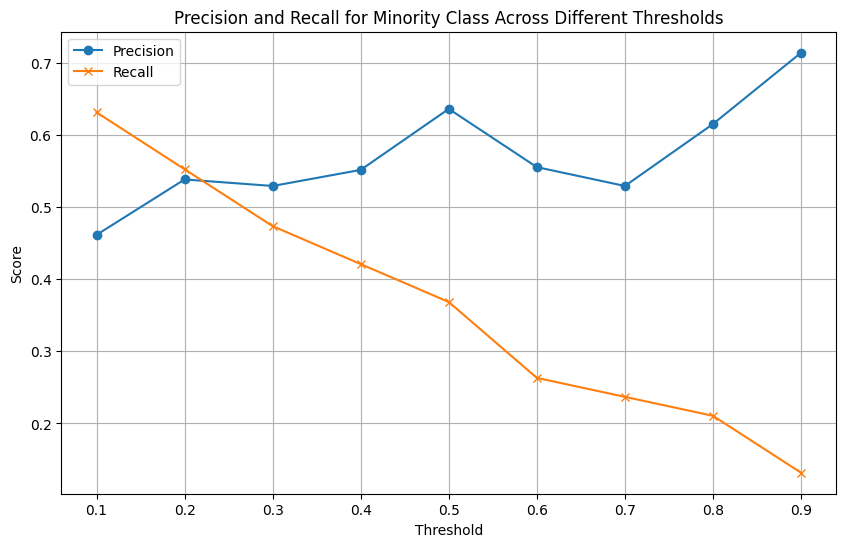

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_test and y_pred_proba are already defined from your model
# and the test data.

# Specify the thresholds you want to evaluate
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to hold precision and recall scores for the minority class
precision_minority = []
recall_minority = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba_llama >= threshold).astype(int)

    # Calculate precision and recall for class 1 (the minority class in this scenario)
    precision_minority.append(precision_score(y_test, y_pred, pos_label=1))
    recall_minority.append(recall_score(y_test, y_pred, pos_label=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_minority, label='Precision', marker='o')
plt.plot(thresholds, recall_minority, label='Recall', marker='x')

plt.title('Precision and Recall for Minority Class Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

## 4.Confustion Matrix

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       153
           1       0.57      0.55      0.56        38

    accuracy                           0.83       191
   macro avg       0.73      0.72      0.73       191
weighted avg       0.83      0.83      0.83       191

{'0': {'precision': 0.8896103896103896, 'recall': 0.8954248366013072, 'f1-score': 0.8925081433224756, 'support': 153.0}, '1': {'precision': 0.5675675675675675, 'recall': 0.5526315789473685, 'f1-score': 0.5599999999999999, 'support': 38.0}, 'accuracy': 0.8272251308900523, 'macro avg': {'precision': 0.7285889785889785, 'recall': 0.7240282077743379, 'f1-score': 0.7262540716612378, 'support': 191.0}, 'weighted avg': {'precision': 0.8255390428165298, 'recall': 0.8272251308900523, 'f1-score': 0.8263546907242868, 'support': 191.0}}


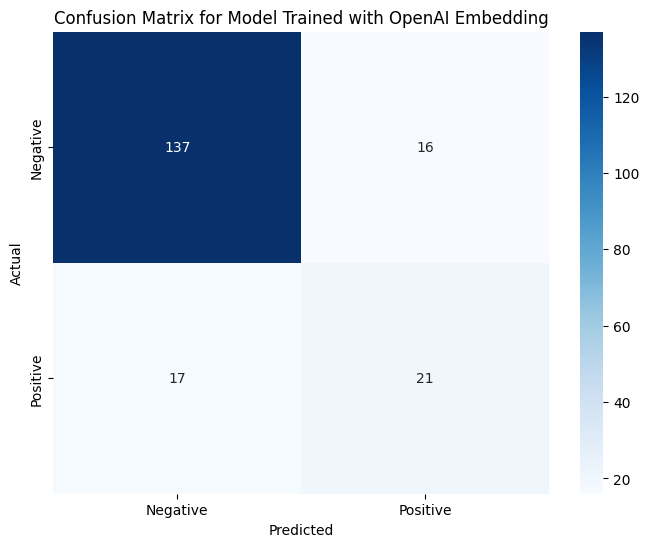

In [48]:
# Set the threshold
threshold = 0.32
y_pred = (y_pred_proba_llama >= threshold).astype(int)
report_llama = classification_report(y_test, y_pred)
print(report_llama)
report_llama = classification_report(y_test, y_pred, output_dict=True)
print(report_llama)

conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model Trained with OpenAI Embedding')
plt.show()

## 5. PR Curve

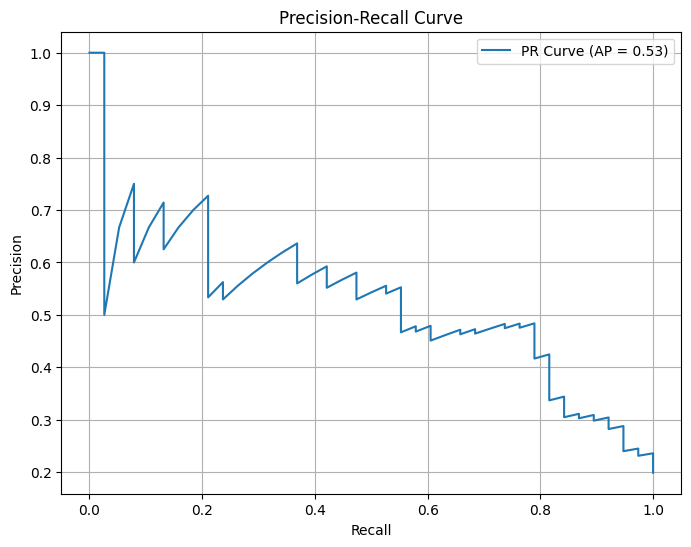

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_llama)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba_llama)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Comparing All The Trained Models

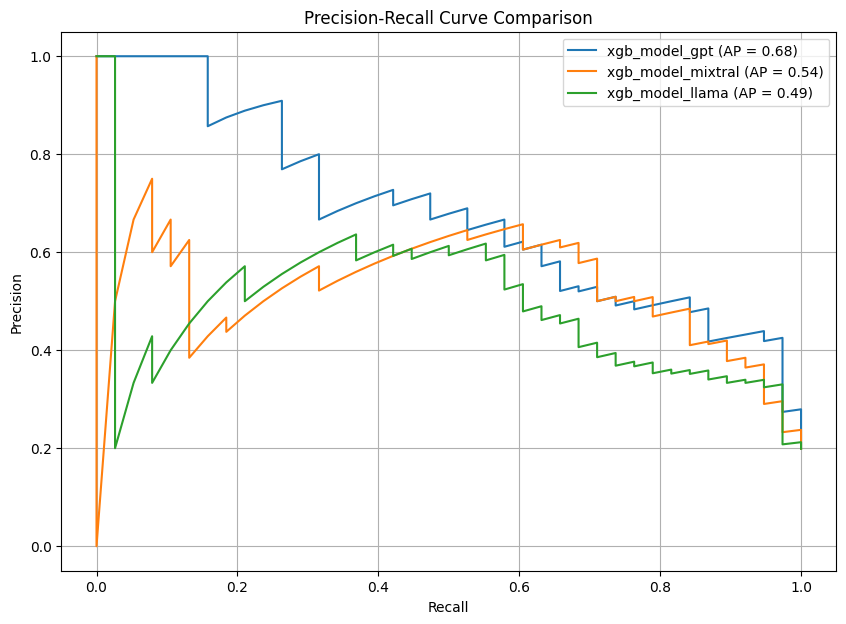

In [27]:
models = ['xgb_model_gpt', 'xgb_model_mixtral', 'xgb_model_llama']
y_pred_probas = [y_pred_proba_gpt, y_pred_proba_mixtral, y_pred_proba_llama]  # Replace with your actual predicted probabilities
average_precisions = []


plt.figure(figsize=(10, 7))

for i, y_pred_proba in enumerate(y_pred_probas):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    average_precision = average_precision_score(y_test, y_pred_proba)
    average_precisions.append(average_precision)

    # Plot the Precision-Recall curve for each model
    plt.plot(recall, precision, label=f'{models[i]} (AP = {average_precision:.2f})')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

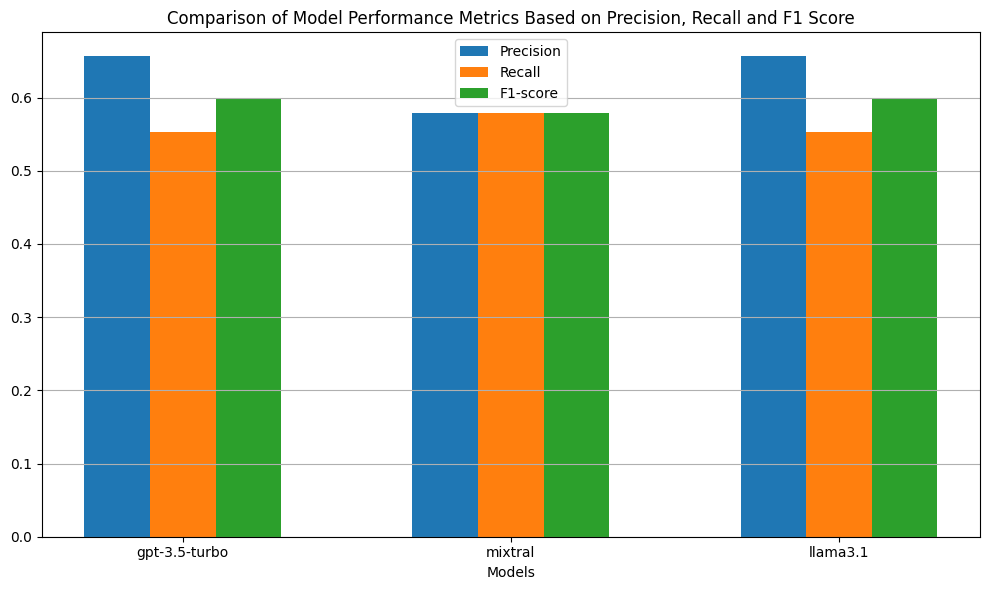

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have the true labels and predicted labels from each model
# y_true = y_test (true labels)
# y_pred_model1, y_pred_model2, y_pred_model3 = predicted labels for each model

# Generate classification reports
# report_model1 = classification_report(y_test, y_pred_model1, output_dict=True)
# report_model2 = classification_report(y_test, y_pred_model2, output_dict=True)
# report_model3 = classification_report(y_test, y_pred_model3, output_dict=True)

# Extract relevant metrics (precision, recall, f1-score) for each model
metrics = ['precision', 'recall', 'f1-score']
model_names = ['gpt-3.5-turbo', 'mixtral', 'llama3.1']
results = {metric: [] for metric in metrics}

for report in [report_gpt, report_mixtral, report_gpt]:
    for metric in metrics:
        results[metric].append(report['1'][metric])  # Assuming '1' is the positive class

# Create a bar plot for the comparison of metrics
x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Loop through metrics to plot
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, results[metric], width, label=metric.capitalize())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_title('Comparison of Model Performance Metrics Based on Precision, Recall and F1 Score')
ax.set_xticks(x + width)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()